In [16]:
# Code to check if we're in collab or on a local environment
try:
    import google.collab
    IN_COLLAB = True
except:
    IN_COLLAB = False

# Setup file paths
if (IN_COLLAB):
    path_map = {'DS_ROOT': Path('/datasets')}
    path_map['RUNS'] = Path('/runs/detect')
else:
    path_map = {'DS_ROOT': Path('./datasets')}
    path_map['RUNS'] = Path('./runs/detect')

# Src data
path_map['DS_ONE'] = path_map['DS_ROOT'] / 'D-Fire'
path_map['DS_ONE_IMG'] = path_map['DS_ONE'] / 'images'
path_map['DS_ONE_LAB'] = path_map['DS_ONE'] / 'labels'
path_map['DS_ONE_YAML'] = path_map['DS_ONE'] / 'data.yaml'

path_map['DS_ONE_RUNS'] = path_map['RUNS'] / 'D-Fire'
path_map['DS_ONE_VAL'] = path_map['RUNS'] / 'val'

# Confirm file paths
def create_dirs():
    print('Creating dir structure...')
    for name, path in path_map.items():
        if isinstance(path, Path) and not path.suffix:
            path = path.resolve()
            path_map[name] = path
            path.mkdir(parents=True, exist_ok=True)
            print(name,'  ',path)
    print('Done!')

create_dirs()

Creating dir structure...
DS_ROOT    /home/evan/Documents/code/school/470/SmokeDetection/datasets
RUNS    /home/evan/Documents/code/school/470/SmokeDetection/runs/detect
DS_ONE    /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire
DS_ONE_IMG    /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/images
DS_ONE_LAB    /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/labels
DS_ONE_RUNS    /home/evan/Documents/code/school/470/SmokeDetection/runs/detect/D-Fire
DS_ONE_VAL    /home/evan/Documents/code/school/470/SmokeDetection/runs/detect/val
Done!


In [18]:
# Dataset utils from https://github.com/gaiasd/DFireDataset
def non_negative(coord):
    
    """
        Sets negative coordinates to zero. This fixes bugs in some labeling tools.
        
        Input:
            coord: Int or float
            Any number that represents a coordinate, whether normalized or not.
    """
    
    if coord < 0:
        return 0
    else:
        return coord
    
def pixel2yolo(dim, pixel_coords):
    
    """
        Transforms coordinates in YOLO format to coordinates in pixels.
        
        Input:
            dim: Tuple or list
            Image size (width, height).
            pixel_coords: List
            Bounding box coordinates in pixels (xmin, ymin, xmax, ymax).
        Output:
            yolo_coords: List
            Bounding box coordinates in YOLO format (xcenter, ycenter, width, height).
    """
    
    dw = 1/dim[0]
    dh = 1/dim[1]
    xcenter = non_negative(dw*(pixel_coords[0] + pixel_coords[2])/2)
    ycenter = non_negative(dh*(pixel_coords[1] + pixel_coords[3])/2)
    width = non_negative(dw*(pixel_coords[2] - pixel_coords[0]))
    height = non_negative(dh*(pixel_coords[3] - pixel_coords[1]))
    
    yolo_coords = [xcenter, ycenter, width, height]
    
    return yolo_coords

def yolo2pixel(dim, yolo_coords):
    
    """
        Transforms coordinates in YOLO format to coordinates in pixels.
        
        Input:
            dim: Tuple or list
            Image size (width, height).
            yolo_coords: List
            Bounding box coordinates in YOLO format (xcenter, ycenter, width, height).
        Output:
            pixel_coords: List
            Bounding box coordinates in pixels (xmin, ymin, xmax, ymax).
    """
    
    xmin = non_negative(round(dim[0] * (yolo_coords[0] - yolo_coords[2]/2)))
    xmax = non_negative(round(dim[0] * (yolo_coords[0] + yolo_coords[2]/2)))
    ymin = non_negative(round(dim[1] * (yolo_coords[1] - yolo_coords[3]/2)))
    ymax = non_negative(round(dim[1] * (yolo_coords[1] + yolo_coords[3]/2)))
    
    pixel_coords = [xmin, ymin, xmax, ymax]
    
    return pixel_coords

In [1]:
import sys
import torch
import locale
from torch import cuda
import skimage.io as io
from pathlib import Path
import supervision as sv
from ultralytics import YOLO
from matplotlib import pyplot as plt
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
has_gpu = cuda.is_available()
device = torch.device('cuda' if  has_gpu else 'cpu')
print(device)
def reset_gpu():
    if has_gpu:
        cuda.empty_cache()

cuda


In [6]:
reset_gpu()
model = YOLO("yolo11n.pt")

results=model.train(
    data="/home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/data.yaml", 
    freeze = 10,
    epochs = 100, 
    patience = 100,
    imgsz = 640, 
    batch = 8, 
    device = 0,
    optimizer= "AdamW",
    lr0 = 0.001,
    iou = 0.7
)

New https://pypi.org/project/ultralytics/8.3.28 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.23 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16050MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/data.yaml, epochs=100, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, cl

train: Scanning /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-F
val: Scanning /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fir

val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0296875]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10770.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0078125]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10775.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.015625]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10821.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.009375]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB11090.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0027778]
val: WARNING ⚠️ /home/evan/

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.765G      1.536      2.039      1.611         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.584      0.216      0.265      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.774G       1.53      1.635      1.584         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.374      0.334       0.32      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.805G       1.48      1.524      1.532         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.391       0.41       0.37      0.163

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.784G      1.448      1.472      1.524         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.391      0.384      0.368      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.776G      1.452      1.429      1.528         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.472      0.397      0.399      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.776G      1.436      1.372       1.49         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.47      0.414      0.408      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.784G      1.366      1.344      1.474         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658       0.48      0.453      0.443      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.774G      1.373      1.282      1.464         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.435      0.444      0.407       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.772G       1.37      1.289       1.47         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.482      0.428      0.412      0.183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.768G      1.346      1.259      1.424         39        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.516      0.449      0.446      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.776G      1.299      1.185      1.411         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.514      0.463       0.46      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.776G      1.299      1.182      1.401         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.517       0.48       0.48      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.776G       1.31      1.182      1.417         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.499      0.425      0.433      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.774G      1.292      1.159      1.396         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.511      0.467      0.457       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.786G      1.271      1.147       1.38         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.475      0.469      0.462      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.786G      1.243      1.115      1.372         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.534      0.486      0.476       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.772G      1.265      1.129      1.395         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.534      0.476      0.466      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      0.77G       1.24      1.102       1.36         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.512      0.486      0.465      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      0.77G      1.238      1.078      1.355         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.512      0.487      0.465      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.768G      1.228      1.078      1.359         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.524       0.47      0.468      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.774G      1.229      1.073      1.352         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.546      0.458      0.481      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      0.77G      1.205      1.058      1.335         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.56      0.472      0.469      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.772G      1.215      1.038       1.34         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.559      0.469      0.482      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.786G      1.186      1.015      1.325         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.565      0.471      0.495      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.784G      1.194       1.01      1.335         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.535      0.492      0.489      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      0.77G       1.17      1.001      1.321         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.566      0.487      0.495      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.772G      1.155     0.9741      1.289         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.529      0.496      0.478      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.772G       1.13     0.9473      1.283         42        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.535      0.515      0.496      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.772G      1.164     0.9627      1.296         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.574      0.475      0.484      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.786G      1.158     0.9344      1.307         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.568       0.49      0.487      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.774G      1.161     0.9515      1.301         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.556      0.483       0.49      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.774G      1.142     0.9306      1.292         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.546      0.496      0.486      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      0.77G      1.109     0.9152      1.259         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.58      0.491      0.503      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      0.77G      1.125     0.9282      1.273         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.564        0.5      0.506      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.772G      1.098      0.908      1.271         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.555      0.494      0.501      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      0.78G      1.099     0.8846      1.266         37        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.583      0.472      0.492      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.772G      1.106     0.8873      1.258          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.579      0.491      0.498      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      0.78G      1.092     0.8727      1.253         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.565      0.498      0.493      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.774G       1.07     0.8586       1.25         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.552      0.496      0.497      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.768G      1.075     0.8591      1.244         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.557       0.52      0.509      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.786G      1.087     0.8584      1.241         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.522      0.511      0.493      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      0.77G      1.064     0.8289      1.232         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.55      0.497      0.494      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.768G      1.077     0.8587      1.235         35        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.571      0.495      0.502      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.768G      1.049     0.8322      1.234         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.575      0.475      0.497      0.241

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      0.77G      1.056     0.8299      1.231         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.572      0.496      0.508      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.786G      1.055     0.8344      1.229         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.564      0.517      0.518      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.772G      1.057     0.8208      1.223          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.571      0.509      0.515      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.768G      1.039     0.7982      1.227         27        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.601      0.493      0.523      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      0.77G      1.024     0.8045      1.209         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.603      0.485      0.512      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      0.77G       1.04     0.7993      1.225         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.618      0.493      0.526       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.768G      1.052     0.8064      1.226         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.602      0.475      0.505      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.793G      1.017     0.7765      1.201         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.573      0.506      0.517       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.772G      1.024     0.7925      1.205         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.588      0.494      0.515      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.786G      1.009      0.783      1.198         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.563      0.488      0.497      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.768G      1.007     0.7834      1.192         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.573      0.512      0.517      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.774G          1     0.7535      1.187         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.575       0.51      0.521      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.772G     0.9791     0.7462      1.181         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.603      0.482      0.505      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.768G     0.9827     0.7344      1.186         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.594      0.482      0.508      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.772G     0.9852     0.7335      1.171         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.565      0.491      0.502      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      0.77G     0.9853     0.7314      1.185         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.577      0.486      0.505      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.772G     0.9666     0.7369      1.181         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.59      0.505      0.518      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.772G     0.9727     0.7312      1.164         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.581      0.514      0.524      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      0.77G     0.9654     0.7207      1.174         25        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.592      0.478      0.508       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.768G     0.9495     0.7078       1.17         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.59      0.501      0.512      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.768G     0.9723     0.7142      1.161         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.605      0.479      0.514      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      0.77G      0.968     0.7232      1.169         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.587      0.505      0.519      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      0.77G     0.9577     0.7034      1.164         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.572      0.502      0.513      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.768G     0.9552     0.7165      1.154         20        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.564      0.505      0.516      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      0.77G     0.9408      0.705      1.153         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.554      0.528      0.517      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.772G      0.927      0.687      1.158         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.588      0.499      0.524      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.772G     0.9272     0.6876      1.163         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.583      0.508      0.518      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      0.77G     0.9508     0.6982      1.159         11        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.588      0.493      0.511      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.772G     0.9308     0.6847      1.148         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.57      0.498      0.511      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.763G     0.9281      0.692       1.15         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.585      0.493      0.512      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.784G     0.9275     0.6784      1.137         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.577      0.506      0.516       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.772G     0.9204     0.6816      1.154         22        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.582      0.508      0.517      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.772G     0.9036     0.6618      1.134         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.586      0.497      0.515      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.772G     0.8901     0.6577      1.127         15        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.595        0.5      0.517      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.768G     0.8831     0.6424      1.125         23        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.592      0.511      0.523      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.774G     0.9164     0.6638      1.138         18        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.587      0.495      0.506      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.768G        0.9     0.6647       1.13         21        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.596      0.494      0.518      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      0.78G     0.8945     0.6611      1.122         19        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.58      0.503      0.516      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.768G     0.8801      0.633      1.124         24        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.572      0.506      0.513      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.774G     0.8913     0.6411      1.125         17        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.606      0.487      0.508      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.774G     0.8962     0.6511      1.127         14        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.582      0.522      0.523      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.786G     0.8952     0.6375      1.119         29        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.597      0.493      0.516      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.772G     0.8665     0.6324      1.107         16        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.591      0.498      0.515       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.772G     0.8567     0.6092      1.109         12        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.604      0.503      0.523      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.772G     0.8894     0.6266      1.123          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.614      0.496      0.524      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.763G     0.8662      0.625      1.112         13        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.594      0.505      0.522      0.261


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      0.82G     0.9842     0.6969      1.191          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.559      0.487      0.479      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.772G     0.9558     0.6472      1.175          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.565      0.476      0.485      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.772G      0.937     0.6492      1.157          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.581      0.484      0.494      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      0.77G     0.9323     0.6414      1.162         10        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.603      0.483      0.502       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.768G     0.9122     0.6216      1.148          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.595      0.483      0.497      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      0.77G     0.9218     0.6278      1.144          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.578       0.49      0.499      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      0.77G     0.9233     0.6165      1.146          8        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658       0.61       0.48      0.502       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.765G     0.9129     0.6332      1.145          9        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658        0.6      0.477      0.498      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.77G     0.8896     0.5952      1.137          6        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.608      0.479      0.501      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      0.77G     0.8996     0.6089      1.133          7        640: 1
                 Class     Images  Instances      Box(P          R      mAP50  m

                   all       1090       2658      0.615      0.476      0.504      0.252



100 epochs completed in 0.324 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.23 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16050MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.592      0.509      0.522      0.264
                 smoke       1044       1202      0.708      0.656      0.686       0.39
                  fire        517       1456      0.476      0.362      0.357      0.137
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train


In [8]:
model = YOLO("./runs/detect/train/weights/best.pt")
metrics = model.val()

Ultralytics 8.3.23 🚀 Python-3.10.15 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 16050MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fir

val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10769.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0296875]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10770.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0078125]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10775.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.015625]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB10821.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.009375]
val: WARNING ⚠️ /home/evan/Documents/code/school/470/SmokeDetection/datasets/D-Fire/val/images/WEB11090.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.0027778]
val: WARNING ⚠️ /home/evan/


                 Class     Images  Instances      Box(P          R      mAP50  m


                   all       1090       2658      0.594      0.511      0.522      0.264
                 smoke       1044       1202       0.71      0.658      0.687      0.391
                  fire        517       1456      0.478      0.365      0.358      0.137
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val


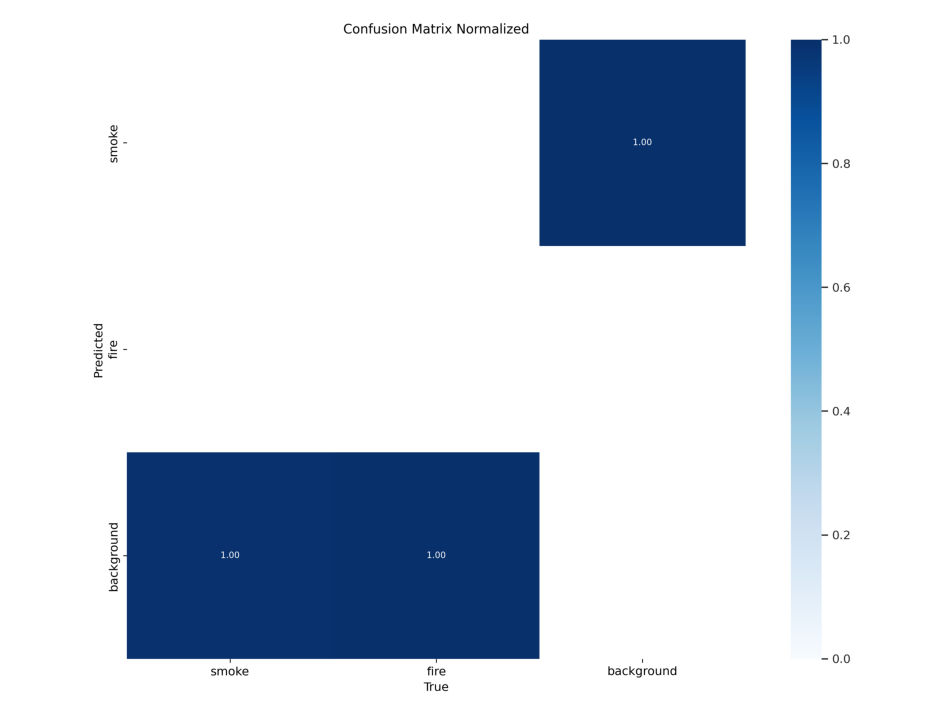

In [48]:
%matplotlib inline
fig, ax = plt.subplots(1, 1,figsize=(12, 12))
ax.imshow(io.imread(path_map['DS_ONE_VAL'] / 'confusion_matrix_normalized.png'))
ax.axis('off')
plt.show()

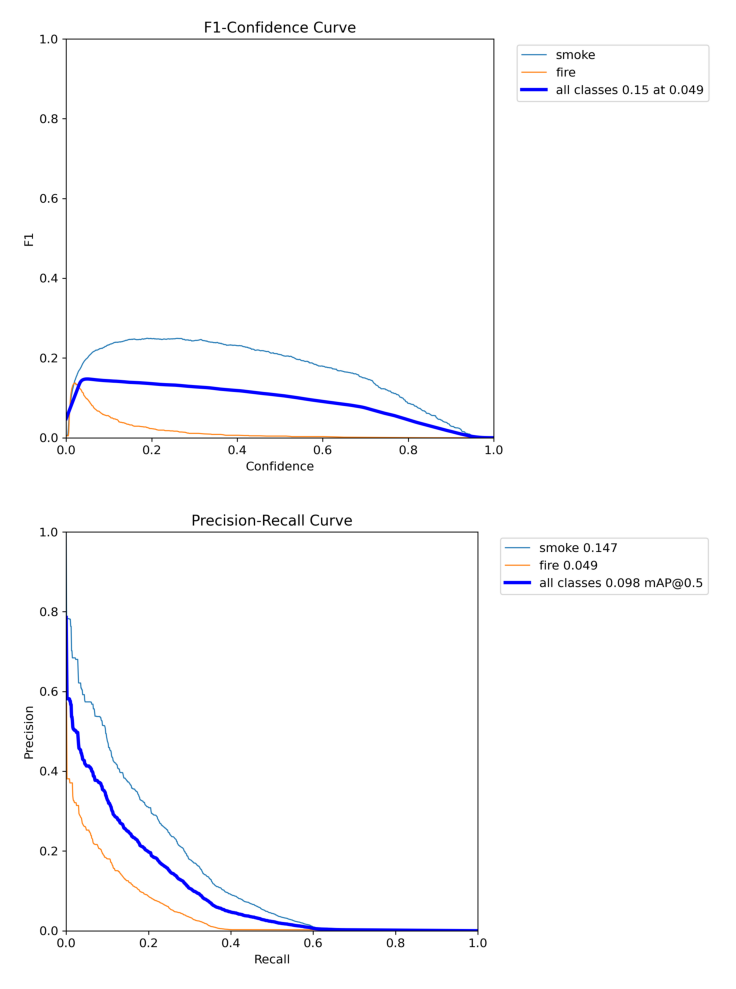

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes[0].imshow(io.imread(path_map['DS_ONE_VAL'] / 'F1_curve.png'))
axes[0].axis('off')
axes[1].imshow(io.imread(path_map['DS_ONE_VAL'] / 'PR_curve.png'))
axes[1].axis('off')
plt.tight_layout()
plt.show()

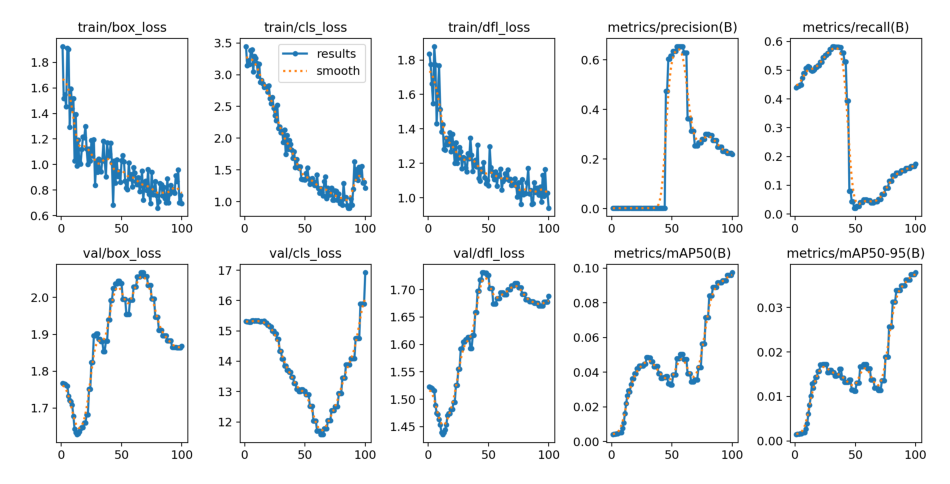

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
ax.imshow(io.imread(path_map['DS_ONE_RUNS'] / 'results.png'))
ax.axis('off')
plt.show()